In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy import stats
import statistics as stat

In [5]:
ds=pd.read_csv("TrainingDataset.arff.txt",header=None, comment='@')
#ds=shuffle(ds)
train, test = train_test_split(ds, test_size=0.2)


In [6]:
#feature selection
corr= train.corr().abs()
columns= np.full((corr.shape[0],),True, dtype=bool)
for i in range(corr.shape[0]):
    if corr.iloc[i,corr.shape[0]-1]<0.1:
        columns[i]=False 
        
selected_columns=train.columns[columns]
train= train[selected_columns]   
test=test[selected_columns]
print(np.shape(train))

(8844, 12)


In [7]:
X_test = test.iloc[:,:np.shape(train)[1]-1]
Y_test = test.iloc[:,-1]

start_time= time.time()

C_range = np.logspace(-3 , 3, num=7)
parameters = {'C':C_range, 'kernel':['linear']}
train_scores_matrix = []
validation_scores_matrix = []
test_scores_matrix = []
best_estimators=[]

for n in range(0,10): 
    elapsed_time= time.time()
    print("\nIterazione",n)
    train_scores=[]
    validation_scores=[]
    test_scores=[]
    #mescolo i campioni in train e validation set
    train= shuffle(train)
    X_train = train.iloc[:,:np.shape(train)[1]-1]
    Y_train = train.iloc[:,-1]
    #GridSearch con i parametri definiti sopra
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv=10, scoring="accuracy",n_jobs=-1, return_train_score=True)
    clf.fit(X_train, Y_train)
    best_estimators.append(clf.best_params_)
    
    for i in range(0,len(clf.cv_results_['params'])):
        print ("Modello:",clf.cv_results_['params'][i], "accuracy:",clf.cv_results_['mean_test_score'][i])
    
    print ("Miglior modello:",clf.best_params_)
    
    #combinazioni di parametri
    hyperparameters = []
    for i in clf.cv_results_['params']:
        hyperparameters.append(i)
    
    #score sul test set per ogni combinazione
    for i in hyperparameters:
        temp_class = svm.SVC(kernel=i['kernel'],C=i['C'])
        temp_class.fit(X_train,Y_train)
        #n risultati sul test set 
        test_scores.append(temp_class.score(X_test,Y_test))
        
    for i in range (0,len(clf.cv_results_['mean_test_score'])): 
        validation_scores.append(clf.cv_results_['mean_test_score'][i])  
        train_scores.append(clf.cv_results_['mean_train_score'][i])
    
    #train validation e test scores per ogni shuffle
    train_scores_matrix.append(train_scores)
    validation_scores_matrix.append(validation_scores)
    test_scores_matrix.append(test_scores)
    
    elapsed_time=time.time()-elapsed_time
    print("\nElapsed time:",elapsed_time)


elapsed_time=time.time()-start_time
print("\nTotal elapsed time:",elapsed_time)


Iterazione 0
Modello: {'C': 0.001, 'kernel': 'linear'} accuracy: 0.9139529624604251
Modello: {'C': 0.01, 'kernel': 'linear'} accuracy: 0.918475802804161
Modello: {'C': 0.1, 'kernel': 'linear'} accuracy: 0.9182496607869742
Modello: {'C': 1.0, 'kernel': 'linear'} accuracy: 0.9199457259158752
Modello: {'C': 10.0, 'kernel': 'linear'} accuracy: 0.9201718679330619
Modello: {'C': 100.0, 'kernel': 'linear'} accuracy: 0.9202849389416553
Modello: {'C': 1000.0, 'kernel': 'linear'} accuracy: 0.9201718679330619
Miglior modello: {'C': 100.0, 'kernel': 'linear'}

Elapsed time: 217.13174557685852

Iterazione 1
Modello: {'C': 0.001, 'kernel': 'linear'} accuracy: 0.9135006784260515
Modello: {'C': 0.01, 'kernel': 'linear'} accuracy: 0.917910447761194
Modello: {'C': 0.1, 'kernel': 'linear'} accuracy: 0.9182496607869742
Modello: {'C': 1.0, 'kernel': 'linear'} accuracy: 0.9200587969244686
Modello: {'C': 10.0, 'kernel': 'linear'} accuracy: 0.9200587969244686
Modello: {'C': 100.0, 'kernel': 'linear'} accurac

In [8]:
values = [x['C'] for x in best_estimators]
try:
    best=stat.mode(values)
    print ("miglior modello: C=",best)
    temp_class = svm.SVC(kernel='linear',C=best)
    temp_class.fit(X_train,Y_train)
    t_score=temp_class.score(X_test,Y_test)
    print("Score del miglior modello sul test set:",t_score)
except: 
    print("Esistono più modelli con la stessa frequenza")
    print("Con quale C vuoi eseguire il test?")
    x=input()
    temp_class = svm.SVC(kernel='linear',C=float(x))
    temp_class.fit(X_train,Y_train)
    t_score=temp_class.score(X_test,Y_test)
    print (t_score)

miglior modello: C= 1.0
Score del miglior modello sul test set: 0.9194934418815016


In [9]:
train_means=[]
for i in range(0, np.shape(train_scores_matrix)[1]):
    temp_means=[]
    for j in range(0, np.shape(train_scores_matrix)[0]):
        temp_means.append(train_scores_matrix[j][i])
    train_means.append(np.mean(temp_means))
    
validation_means=[]
for i in range(0, np.shape(validation_scores_matrix)[1]):
    temp_means=[]
    for j in range(0, np.shape(validation_scores_matrix)[0]):
        temp_means.append(validation_scores_matrix[j][i])
    validation_means.append(np.mean(temp_means))
    
test_means=[]
for i in range(0, np.shape(test_scores_matrix)[1]):
    temp_means=[]
    for j in range(0, np.shape(test_scores_matrix)[0]):
        temp_means.append(test_scores_matrix[j][i])
    test_means.append(np.mean(temp_means))



validation scores: [0.913613749434645, 0.9185210312075982, 0.9183627317955677, 0.919606512890095, 0.9196517412935323, 0.919674355495251, 0.919674355495251] 
train scores: [0.9137858657030018, 0.9189645168584812, 0.9189594994669378, 0.9199859282600377, 0.9200537709285884, 0.9200587968434372, 0.9200512596285273] 
test scores: [0.9167797376752601, 0.9176843057440072, 0.9194934418815016, 0.9194934418815016, 0.9194934418815016, 0.9194934418815016, 0.9194934418815016]


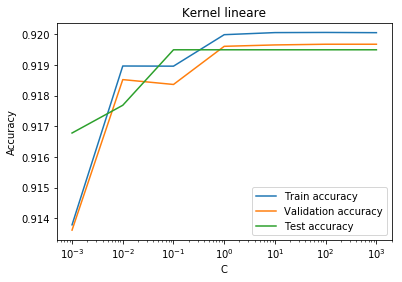

In [10]:
print ("validation scores:",validation_means,"\ntrain scores:",train_means,"\ntest scores:",test_means)
plt.plot(C_range,train_means)
plt.plot(C_range,validation_means)
plt.plot(C_range,test_means)
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.title("Kernel lineare")
plt.legend(['Train accuracy','Validation accuracy','Test accuracy'], prop={'size': 10})
plt.show()


Iterazione 0
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6421302578018996
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9012890094979648
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9133876074174582
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5859339665309815
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Mo

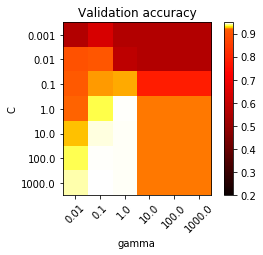


Elapsed time: 385.15284490585327

Iterazione 1
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6424694708276798
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9015151515151515
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9138398914518318
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5841248303934871
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rb

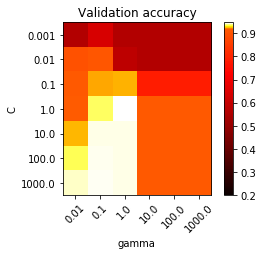


Elapsed time: 389.3227677345276

Iterazione 2


C:\Users\Chiara\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6423563998190864
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9017412935323383
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9133876074174582
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.585820895522388
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.

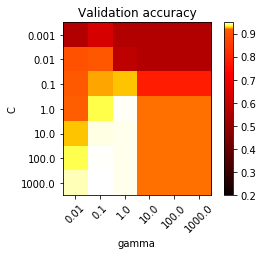


Elapsed time: 388.8312306404114

Iterazione 3
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.642243328810493
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9010628674807779
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9132745364088648
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5862731795567616
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'

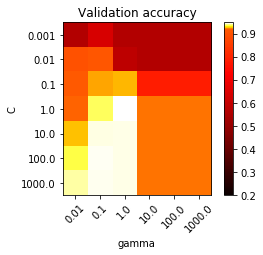


Elapsed time: 381.1724967956543

Iterazione 4
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6426956128448665
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9011759384893713
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9133876074174582
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5860470375395749
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf

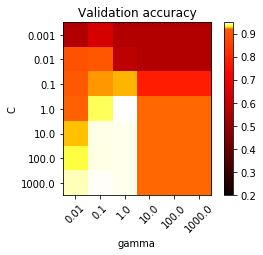


Elapsed time: 373.4974539279938

Iterazione 5


C:\Users\Chiara\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6421302578018996
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9011759384893713
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9131614654002713
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5840117593848937
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0

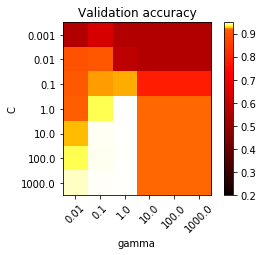


Elapsed time: 380.3625519275665

Iterazione 6


C:\Users\Chiara\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6417910447761194
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9023066485753053
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9137268204432384
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5838986883763003
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0

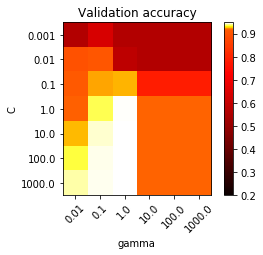


Elapsed time: 378.8579111099243

Iterazione 7
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.642243328810493
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9012890094979648
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9132745364088648
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5860470375395749
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'

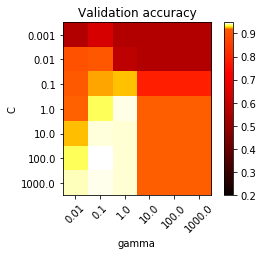


Elapsed time: 373.51586985588074

Iterazione 8
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6419041157847128
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9011759384893713
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9137268204432384
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5846901854364541
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rb

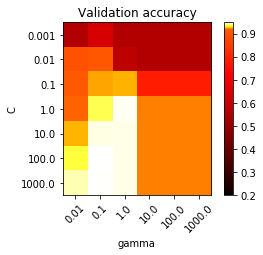


Elapsed time: 374.9763686656952

Iterazione 9
Modello: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.6415649027589326
Modello: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} accuracy: 0.9017412935323383
Modello: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} accuracy: 0.9132745364088648
Modello: {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'} accuracy: 0.5866123925825418
Modello: {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'} accuracy: 0.560719131614654
Modello: {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf

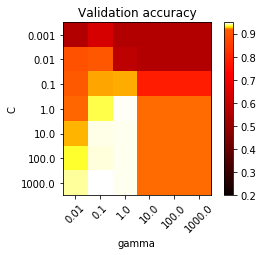


Elapsed time: 382.02235102653503

Total elapsed time: 3807.7128808498383


In [11]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
start_time= time.time()

C_range = np.logspace(-3 , 3, num=7)
Gamma_range = np.logspace(-2 , 3, num=6)
parameters = {'C':C_range, 'gamma':Gamma_range,'kernel':['rbf']}

train_scores_matrix = []
validation_scores_matrix = []
test_scores_matrix = []
best_estimators=[]

for n in range(0,10): 
    elapsed_time= time.time()
    print("\nIterazione",n)
    train_scores_c_perIter = []
    validation_scores_c_perIter = []
    test_scores_c_perIter = []
    
    #mescolo i campioni in train e validation set
    train= shuffle(train)
    X_train = train.iloc[:,:np.shape(train)[1]-1]
    Y_train = train.iloc[:,-1]
    #GridSearch con i parametri definiti sopra
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv=10, scoring="accuracy",n_jobs=-1, return_train_score=True)
    clf.fit(X_train, Y_train)
    best_estimators.append(clf.best_params_)
    
    for i in range(0,len(clf.cv_results_['params'])):
        print ("Modello:",clf.cv_results_['params'][i], "accuracy:",clf.cv_results_['mean_test_score'][i])
    
    print ("Miglior modello:",clf.best_params_)

    # Draw heatmap of the validation accuracy as a function of gamma and C
    # The score are encoded as colors with the hot colormap which varies from dark
    # red to bright yellow. As the most interesting scores are all located in the
    # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
    # as to make it easier to visualize the small variations of score values in the
    # interesting range while not brutally collapsing all the low score values to
    # the same color.
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(Gamma_range))

    plt.figure(figsize=(5, 3))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(Gamma_range)), Gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()
    
    
    ################    
    i=0
    maxdim=len(Gamma_range)
    while(i<len(clf.cv_results_['params'])):
        
        c=clf.cv_results_['params'][i]['C']

        train_scores_gamma_perC=[]
        validation_scores_gamma_perC=[]
        test_scores_gamma_perC=[]
        for j in range(i, i+maxdim):
            gamma=clf.cv_results_['params'][j]['gamma']
            validation_scores_gamma_perC.append(clf.cv_results_['mean_test_score'][j])  
            train_scores_gamma_perC.append(clf.cv_results_['mean_train_score'][j])
            
            temp_class = svm.SVC(kernel='rbf', C=c, gamma=gamma)
            temp_class.fit(X_train,Y_train)
            #n risultati sul test set 
            test_scores_gamma_perC.append(temp_class.score(X_test,Y_test))
        
        validation_scores_c_perIter.append(validation_scores_gamma_perC)
        train_scores_c_perIter.append(train_scores_gamma_perC)
        test_scores_c_perIter.append(test_scores_gamma_perC)

        i=i+maxdim
    #####################
    
    #train validation e test scores per ogni shuffle
    train_scores_matrix.append(train_scores_c_perIter)
    validation_scores_matrix.append(validation_scores_c_perIter)
    test_scores_matrix.append(test_scores_c_perIter)
    
    
    elapsed_time=time.time()-elapsed_time
    print("\nElapsed time:",elapsed_time)

elapsed_time=time.time()-start_time
print("\nTotal elapsed time:",elapsed_time)

In [ ]:
values=dict()   

for x in best_estimators:
    if str(x) in values.keys():
        values[str(x)]=values[str(x)]+1
    else:
        values[str(x)]=1
print(values)
tot=0
for x in values:
    tot=tot+values[x]
occ=0
best=None
for key in values:
    if values[key]>occ:
        occ=values[key]
        best=key
if occ<tot/2:
    print(best,"occorre",occ,"volte su",tot,".\nProcedere comunque? [y]/[n]")
    choice=input()
    if choice=='n':
        sys.exit()
    
import ast
parameters=ast.literal_eval(best)
temp_class = svm.SVC(kernel='rbf',C=parameters['C'],gamma=parameters['gamma'])
temp_class.fit(X_train,Y_train)
t_score=temp_class.score(X_test,Y_test)
print("Score del miglior modello sul test set:",t_score)

In [22]:
train_means=[]
for g in range(0, np.shape(train_scores_matrix)[2]):
    temp_means=[]
    for c in range(0,np.shape(train_scores_matrix)[1]):
        gammac=[]
        for i in range(0, np.shape(train_scores_matrix)[0]):
            gammac.append(train_scores_matrix[i][c][g])
        temp_means.append(np.mean(gammac))
    train_means.append(temp_means)

validation_means=[]
for g in range(0, np.shape(validation_scores_matrix)[2]):
    temp_means=[]
    for c in range(0,np.shape(validation_scores_matrix)[1]):
        gammac=[]
        for i in range(0, np.shape(validation_scores_matrix)[0]):
            gammac.append(validation_scores_matrix[i][c][g])
        temp_means.append(np.mean(gammac))
    validation_means.append(temp_means)

test_means=[]
for g in range(0, np.shape(test_scores_matrix)[2]):
    temp_means=[]
    for c in range(0,np.shape(test_scores_matrix)[1]):
        gammac=[]
        for i in range(0, np.shape(test_scores_matrix)[0]):
            gammac.append(test_scores_matrix[i][c][g])
        temp_means.append(np.mean(gammac))
    test_means.append(temp_means)
      


train scores:
 [[0.5582315701975895, 0.9081297971978264, 0.9206706470586387, 0.9347957263515397, 0.9488366273710989, 0.9678601911545824, 0.9795743544919061], [0.5582315701975895, 0.8225124421181353, 0.939123829719007, 0.9676730056954529, 0.9846235908598203, 0.9896439483795225, 0.9902809163638688], [0.5582315701975895, 0.5582315701975895, 0.5994170355454571, 0.9896942027930831, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223], [0.5582315701975895, 0.5582315701975895, 0.5606952644929304, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223], [0.5582315701975895, 0.5582315701975895, 0.5606952644929304, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223], [0.5582315701975895, 0.5582315701975895, 0.5606952644929304, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223, 0.9902846856816223]] 
validation scores:
 [[0.5582315694255993, 0.9079375848032564, 0.9200927182270465, 0.9325305291723204, 0.9440976933514247, 0.9559475

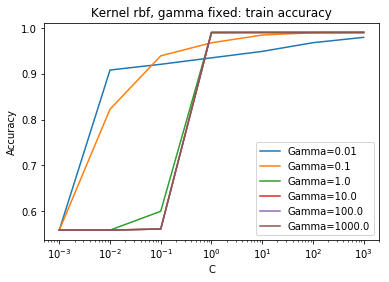

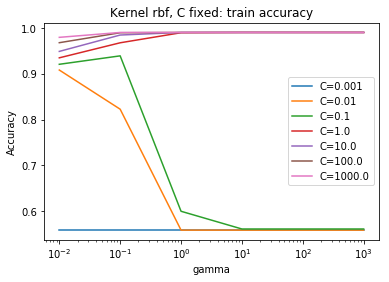

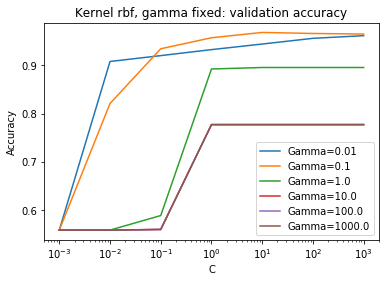

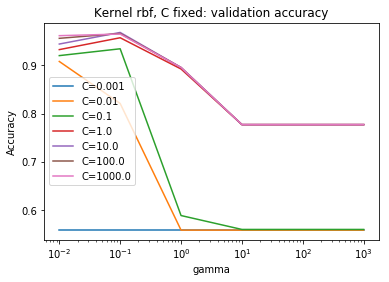

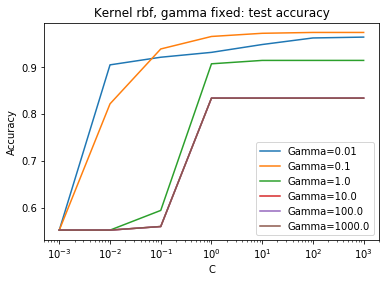

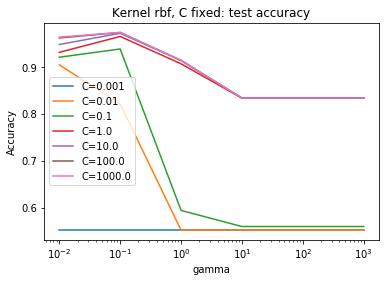

In [23]:
print ("\ntrain scores:\n",train_means,"\nvalidation scores:\n",validation_means,"\ntest scores:\n",test_means)

labelgamma=[]
for i in Gamma_range:
    labelgamma.append("Gamma="+str(i))
labelC=[]
for i in C_range:
    labelC.append("C="+str(i))
    

#plt.subplot(321)
for i in range(0,np.shape(train_means)[0]):
    plt.plot(C_range,train_means[i])
plt.title('Kernel rbf, gamma fixed: train accuracy')
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelgamma, prop={'size': 10})
plt.show()

train_means=np.transpose(train_means)
#plt.subplot(322)
for i in range(0,np.shape(train_means)[0]):
    plt.plot(Gamma_range,train_means[i])
plt.title('Kernel rbf, C fixed: train accuracy')
plt.xlabel("gamma")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelC, prop={'size': 10})
plt.show()

#plt.subplot(323)
for i in range(0,np.shape(validation_means)[0]):
    plt.plot(C_range,validation_means[i])
plt.title('Kernel rbf, gamma fixed: validation accuracy')
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelgamma, prop={'size': 10})
plt.show()

validation_means=np.transpose(validation_means)
#plt.subplot(324)
for i in range(0,np.shape(validation_means)[0]):
    plt.plot(Gamma_range,validation_means[i])
plt.title('Kernel rbf, C fixed: validation accuracy')
plt.xlabel("gamma")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelC, prop={'size': 10})
plt.show()

#plt.subplot(325)
for i in range(0,np.shape(test_means)[0]):
    plt.plot(C_range,test_means[i])
plt.title('Kernel rbf, gamma fixed: test accuracy')
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelgamma, prop={'size': 10})
plt.show()

test_means=np.transpose(test_means)
#plt.subplot(326)
for i in range(0,np.shape(test_means)[0]):
    plt.plot(Gamma_range,test_means[i])
plt.title('Kernel rbf, C fixed: test accuracy')
plt.xlabel("gamma")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.legend(labelC, prop={'size': 10})
plt.show()
